# Modelo de Crecimiento Neoclásico con Agentes   Heterogéneos y Riesgo Agregado

# (Método de Perturbación)

Mauricio Tejada

ILADES - Universidad Alberto Hurtado

In [1]:
using NLsolve, Plots

## El Modelo

El modelo en su forma recursiva:

$$
\begin{aligned}V\left(a_{i},e_{i};z,k\right)= & \max_{\left\{ c_{i},a_{i}^{\prime}\right\} }\left\{ \frac{c_{i}^{1-\gamma}-1}{1-\gamma}+\beta E\left[V\left(a_{i}^{\prime},e_{i}^{\prime};z^{\prime},k^{\prime}\right)-\phi\mathbf{P}\left(a_{i}^{\prime}\right)\right]\right\} \\
 & \text{ s.t }\quad(1-\delta)a_{i}+r(k,l,z)a_{i}+w(k,l,z)e_{i}\bar{l}-c_{i}-a_{i}^{\prime}\geq0\\
 & z^{\prime}=\left(1-\rho_{z}\right)\mu_{z}+\rho_{z}z+\varepsilon^{\prime z}\\
 & e_{i}^{\prime}=\left(1-\rho_{e}\right)\mu_{e}+\rho_{e}e_{i}+\varepsilon_{i}^{\prime e}\\
 & k^{\prime}=\zeta_{0}+\zeta_{1}k+\zeta_{2}z
\end{aligned}
$$

con $\mathbf{P}\left(a_{i}^{\prime}\right)=\frac{1}{\left(a_{i}^{\prime}+b\right)^{2}}-\eta\left(a_{i}^{\prime}+b\right)$.

Adicionalmente, tenemos que:

$$
\begin{aligned}r\left(k,l,z\right) & =\alpha z\left(\frac{k}{l}\right)^{\alpha-1}\\
w\left(k,l,z\right) & =(1-\alpha)z\left(\frac{k}{l}\right)^{\alpha}
\end{aligned}
$$

El método usado usará la perturbación alrededor del estado estacionario sin riesgo idiosincrático.

Note que $l=\int l_{i}di=\bar{l}\int e_{i}di=\bar{l}\mu_{e}$ y $k=\int a_{i}di$

## Condiciones de Equilibrio

\begin{align*}
c_{i}^{-\gamma} & =\beta E\left[c_{i}^{'-\gamma}\left[1-\delta+r'\right]+\phi\left(\frac{2}{a_{i}^{\prime}+b}+\eta\right)\right]\\
c_{i}+a_{i}^{\prime} & =(1-\delta)a_{i}+ra_{i}+we_{i}\bar{l}\\
r & =\alpha \left(\frac{k}{\bar{l}\mu_{e}}\right)^{\alpha-1}\\
w & =(1-\alpha)\left(\frac{k}{\bar{l}\mu_{e}}\right)^{\alpha}\\
z^{\prime} & =\left(1-\rho_{z}\right)\mu_{z}+\rho_{z}z+\varepsilon^{\prime z}\\
e_{i}^{\prime} & =\left(1-\rho_{e}\right)\mu_{e}+\rho_{e}e_{i}+\varepsilon_{i}^{\prime e}\\
k^{\prime} & =\zeta_{0}+\zeta_{1}k+\zeta_{2}z
\end{align*}

## Agregación Explicita

Den Haan y Ocaktan (2009) muestran que la relación entre la función de política individual y la ecuación de movimiento del capital agregado puede ser hallada por agregación directa en el contexto lineal.

Función de política individual:

$$a_{i}'=\theta_{0}+\theta_{1}a_{i}+\theta_{2}e_{i}+\theta_{3}z+\theta_{4}k$$

Entonces agregando tenemos:

$$
\begin{aligned}k' & = \int a'_{i}di = \theta_{0}+\theta_{1}\int a_{i}di+\theta_{2}\int e_{i}di+\theta_{3}z+\theta_{4}k\\
 & =\left(\theta_{0}+\theta_{2}\mu_{e}\right)+\left(\theta_{1}+\theta_{4}\right)k+\theta_{3}z
 \end{aligned}
 $$
 
 Así $\zeta_0 = \theta_{0}+\theta_{2}\mu_{e}$, $\zeta_1 = \theta_{1}+\theta_{4}$ y $\zeta_2 = \theta_{3}$

In [2]:
# Parámetros del modelo
γ  = 2.0
β  = 0.99
δ  = 0.10
α  = 0.33
l̄  = 1.0
b  = 0.0
μz = 1.0
ρz = 0.9
σz = 0.01
μe = 1
ρe = 0.95
σe = 0.005
η  = -1.5
ϕ  = 0.1;

In [3]:
# Parametros de iteración
tol = 1e-6;
ajuste = 1.0
maxiter = 500;

In [4]:
# Inicializar parametros de la ecuación de transición del capital

ζ_0 = [0.5, 0.5, 0.5];

In [5]:
function sistema_ss(x, exoiv_ee)
    ci, ai = x
    z_ee, ei_ee, k_ee, r_ee, w_ee = exoiv_ee
    
    fx = similar(x)
    
    fx[1] = 1.0 - β*(1 - δ + r_ee) - β*ϕ*(2/((ai+b)^3)+η)
    fx[2] = ci + ai - (1.0 + r_ee - δ)*ai - w_ee*ei_ee*l̄
    
    return fx
        
end

sistema_ss (generic function with 1 method)

In [6]:
# Incluímos funciones necesarias para aplicar el método de perturbación
include("second_order_approx.jl");

# Número de variables y shocks
nx = 4; # variables de estado ai k ei z
ny = 3; # variables de control c w r
ne = 2; # shock epse epsz

In [7]:
for i = 1:maxiter
    
    global Gs, Hs, Gx, Hx, ζ_0
    
    # Parametros de la ecuación de transición del capital
    ζ₀_0 = ζ_0[1]
    ζ₁_0 = ζ_0[2]
    ζ₂_0 = ζ_0[3];

    # Estados Estacionario
    z_ee = μz
    ei_ee = μe
    k_ee = (ζ₀_0+ζ₂_0*z_ee)/(1-ζ₁_0)
    r_ee = α*z_ee*(k_ee/(l̄*μe))^(α-1)
    w_ee = (1-α)*z_ee*(k_ee/(l̄*μe))^α;

    exi_ee = [z_ee, ei_ee, k_ee, r_ee, w_ee]

    # Resolver por el estado estacionari
    solee = nlsolve(x -> sistema_ss(x, exi_ee), [0.5, 1.5], inplace = false)
    ci_ee = solee.zero[1]
    ai_ee = solee.zero[2]

    # Definimos el modelo. Orden de variables
    # ai' k' ei' z' ci' w' r' ai k ei z  ci  w  r
    # 1   2  3   4  5   6  7  8  9 10 11 12 13 14
    # las variables no serán definidas en logs porque eso complica la agregación explícita

    function eq1(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return ci^(-γ) - β*(cil^(-γ))*(1 - δ + rl) - β*ϕ*(2/((ail+b)^3)+η)

    end

    function eq2(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return ci + ail - (1-δ)*ai - r*ai - w*ei*l̄

    end

    function eq3(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return r - α*z*(k/(l̄*μe))^(α-1)

    end

    function eq4(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return w - (1-α)*z*(k/(l̄*μe))^α

    end

    function eq5(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return zl - (1-ρz)*μz - ρz*z

    end

    function eq6(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return eil - (1-ρe)*μe - ρe*ei

    end

    function eq7(x)
        ail, kl, eil, zl, cil, wl, rl, ai, k, ei, z, ci, w, r = x

        return kl - ζ₀_0 - ζ₁_0*k - ζ₂_0*z

    end


    cpo_eqs = (eq1, eq2, eq3, eq4, eq5, eq6, eq7)
    ee = [ai_ee k_ee ei_ee z_ee ci_ee w_ee r_ee ai_ee k_ee ei_ee z_ee ci_ee w_ee r_ee]

    # Calculando las matrices jacobiana y hesiana del sistema
    J, H = compute_gradient_hessian(cpo_eqs,ee);

    # Solución usando una aproximación de primer orden
    Gs,Hs,Gx,Hx = solve_first_order_approx(ee,J,nx,ny,ne);

    θ₀ = ee[1,1] - sum(Hx[1,:].*ee[1,1:4])
    θ₁ = Hx[1,1]
    θ₂ = Hx[1,2]
    θ₃ = Hx[1,3]
    θ₄ = Hx[1,4]

    ζ₀_1 = θ₀ + θ₃*μe
    ζ₁_1 = θ₁ + θ₂
    ζ₂_1 = θ₄

    ζ_1 = [ζ₀_1, ζ₁_1, ζ₂_1]

    diff = maximum(abs.(ζ_1-ζ_0))
    #println(diff)
    
    if diff<tol
        println("Convergencia alcanzada en $i iteraciones!")
        break
    end

    ζ_0 = ajuste*ζ_1 + (1-ajuste)*ζ_0
end

Convergencia alcanzada en 54 iteraciones!


## Impulso Respuesta

In [8]:
# Analisis de impulso respuesta
ETA = [0 0; 0 0; 1 0; 0 1]   
horizonte = 50 
xx_z, yy_z = fir_first_order(Hx,Gx,horizonte,2,ETA,σz);


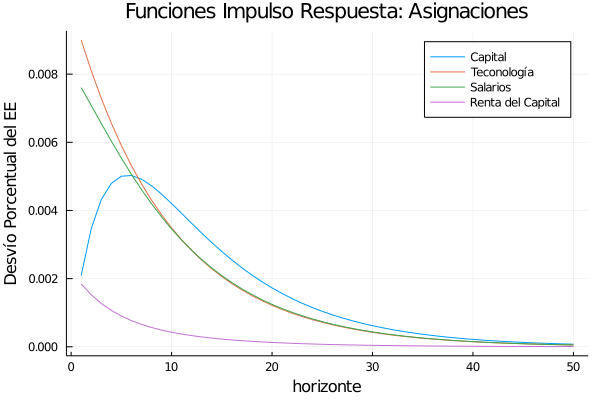

In [9]:
nombre_vars = ["Capital" "Teconología" "Salarios" "Renta del Capital"]

plot(1:horizonte, [xx_z[:,2] xx_z[:,4] yy_z[:,2] yy_z[:,3]],
     xlabel = "horizonte", ylabel = "Desvío Porcentual del EE", label=nombre_vars, 
     title = "Funciones Impulso Respuesta: Asignaciones")